In [968]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, shapiro
from statsmodels.tsa.stattools import kpss

## шаг 1

In [969]:
# Применение теста KPSS
def kpss_test(data_column):
    result = kpss(data_column, regression="c")  # Для проверки стационарности вокруг уровня
    print("KPSS Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[3])

    if result[1] < 0.05:
        print("Ряд нестационарен по kpss")
    else:
        print("Ряд стационарен по kpss")


# # Функция для KPSS теста
# def kpss_test(series):
#     statistic, p_value, _, _ = kpss(series, regression='c')
#     print(f"KPSS Test: Statistic={statistic}, p-value={p_value}")
#     if p_value < 0.05:
#         print("Ряд не стационарен (отвергаем нулевую гипотезу).")
#     else:
#         print("Ряд стационарен (не отвергаем нулевую гипотезу).")

In [970]:

# Чтение данных
file_path = "monthly-electricity-production-i.xlsx"  # Замените на свой путь
data = pd.read_excel(file_path)
data.columns = ["Month", "Units"]
data["Month"] = pd.to_datetime(data["Month"])
data.set_index("Month", inplace=True)

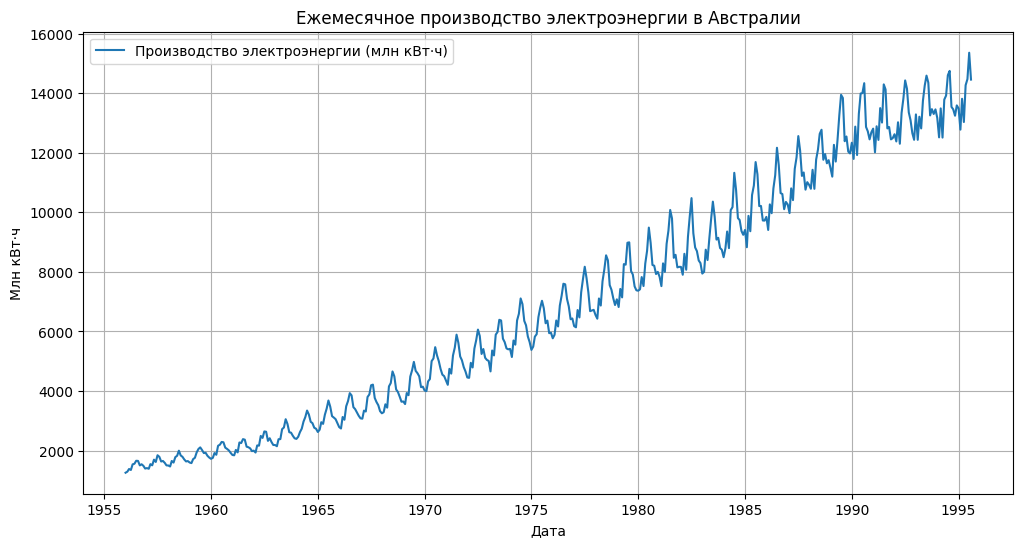

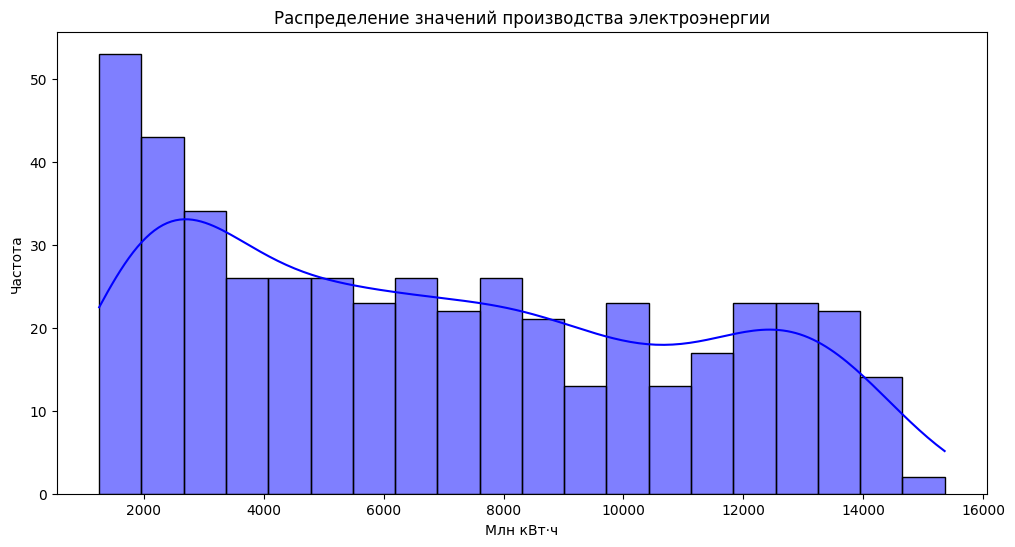

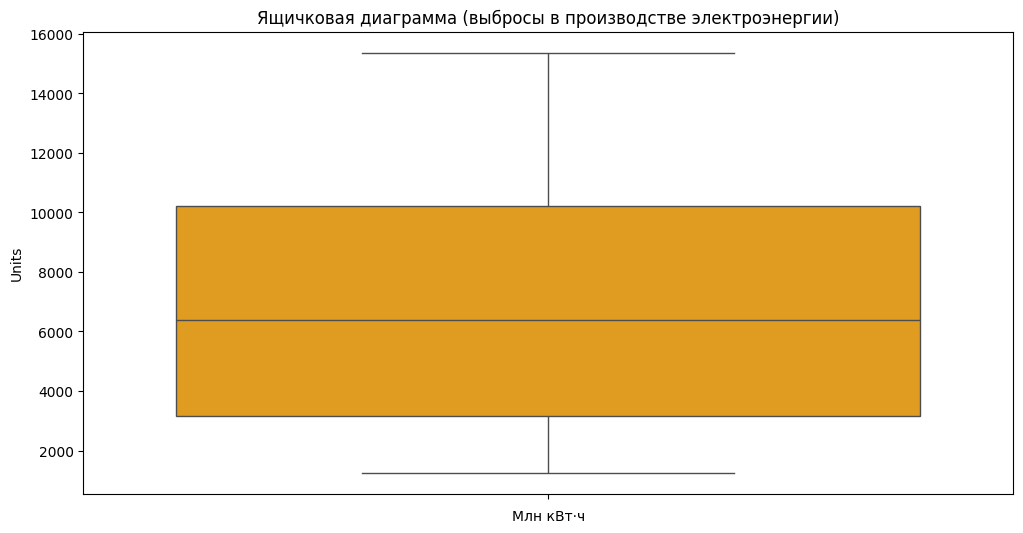

KPSS Statistic: 3.7347040419440876
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд нестационарен по kpss
KPSS Statistic: 3.688409741882398
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд нестационарен по kpss


C:\Users\Varya02\AppData\Local\Temp\ipykernel_12320\40932756.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data_column, regression="c")  # Для проверки стационарности вокруг уровня
C:\Users\Varya02\AppData\Local\Temp\ipykernel_12320\40932756.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data_column, regression="c")  # Для проверки стационарности вокруг уровня


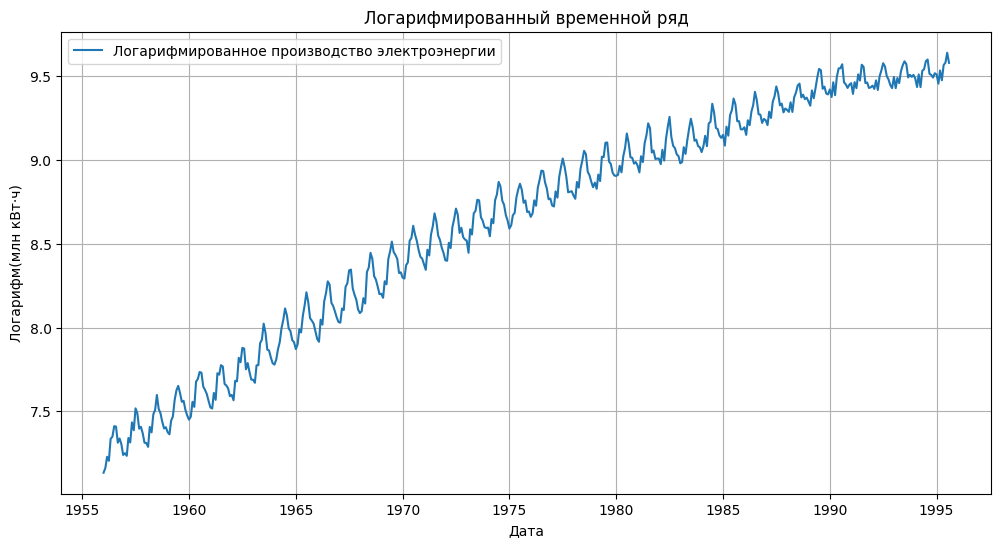

C:\Users\Varya02\AppData\Local\Temp\ipykernel_12320\40932756.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data_column, regression="c")  # Для проверки стационарности вокруг уровня


KPSS Statistic: 0.04693465373638344
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарен по kpss


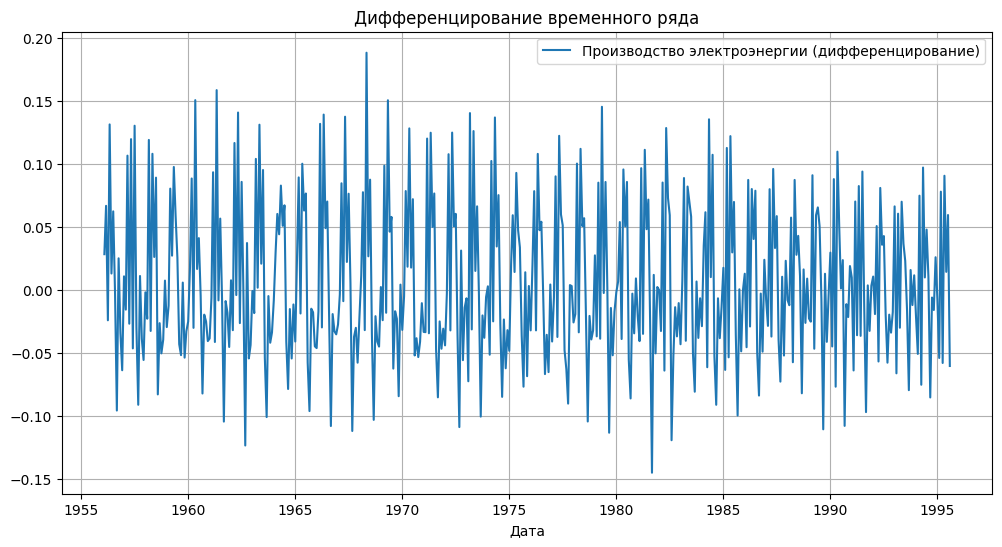

C:\Users\Varya02\AppData\Local\Temp\ipykernel_12320\40932756.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data_column, regression="c")  # Для проверки стационарности вокруг уровня


KPSS Statistic: 0.06668803017761195
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарен по kpss


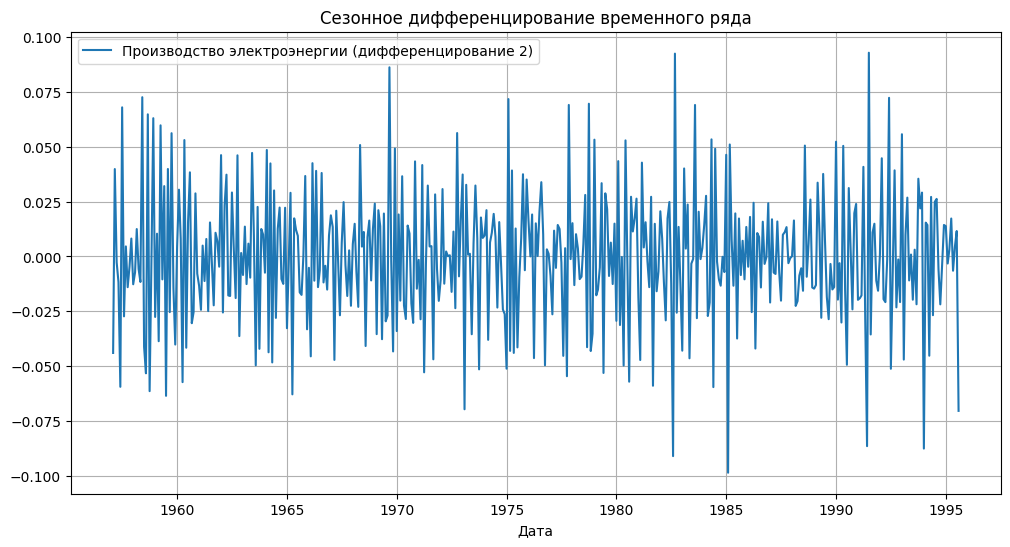

Month
1957-02-01   -0.044041
1957-03-01    0.039869
1957-04-01   -0.002710
1957-05-01   -0.011689
1957-06-01   -0.059493
                ...   
1995-04-01    0.017296
1995-05-01   -0.006521
1995-06-01    0.004448
1995-07-01    0.011588
1995-08-01   -0.070471
Name: Units, Length: 463, dtype: float64

In [971]:


# Визуализация исходного временного ряда
plt.figure(figsize=(12, 6))
plt.plot(data["Units"], label="Производство электроэнергии (млн кВт·ч)")
plt.title("Ежемесячное производство электроэнергии в Австралии")
plt.xlabel("Дата")
plt.ylabel("Млн кВт·ч")
plt.legend()
plt.grid()
plt.show()

# Анализ распределения признака
plt.figure(figsize=(12, 6))
sns.histplot(data["Units"], kde=True, bins=20, color="blue")
plt.title("Распределение значений производства электроэнергии")
plt.xlabel("Млн кВт·ч")
plt.ylabel("Частота")
plt.show()

# Проверка на выбросы с помощью boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data["Units"], color="orange")
plt.title("Ящичковая диаграмма (выбросы в производстве электроэнергии)")
plt.xlabel("Млн кВт·ч")
plt.show()

# KPSS тест для исходного ряда
kpss_test(data["Units"])

# Трансформация 1: Логарифмирование
log_series = np.log(data["Units"])
kpss_test(log_series)

plt.figure(figsize=(12, 6))
plt.plot(log_series, label="Логарифмированное производство электроэнергии")
plt.title("Логарифмированный временной ряд")
plt.xlabel("Дата")
plt.ylabel("Логарифм(млн кВт·ч)")
plt.legend()
plt.grid()
plt.show()

# Трансформация 2: Дифференцирование
diff_series_1 = log_series.diff().dropna()
kpss_test(diff_series_1)

plt.figure(figsize=(12, 6))
plt.plot(diff_series_1, label="Производство электроэнергии (дифференцирование)")
plt.title("Дифференцирование временного ряда")
plt.xlabel("Дата")
plt.legend()
plt.grid()
plt.show()



# Трансформация 3: Дифференцирование
diff_series_2 = diff_series_1.diff(12).dropna()
kpss_test(diff_series_2)

plt.figure(figsize=(12, 6))
plt.plot(diff_series_2, label="Производство электроэнергии (дифференцирование 2)")
plt.title("Сезонное дифференцирование временного ряда")
plt.xlabel("Дата")
plt.legend()
plt.grid()
plt.show()

resData = diff_series_2
diff_series_2

In [972]:
Q1 = data["Units"].quantile(0.25)  # Первый квартиль
Q3 = data["Units"].quantile(0.75)  # Третий квартиль
IQR = Q3 - Q1  # Межквартильный размах

print(f'{Q1=}')
print(f'{Q3=}')

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data["Units"] < lower_bound) | (data["Units"] > upper_bound)]

print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")
print(f"Количество выбросов: {len(outliers)}")

Q1=np.float64(3146.75)
Q3=np.float64(10224.75)
Нижняя граница: -7470.25
Верхняя граница: 20841.75
Количество выбросов: 0


In [973]:
def inverse_transform(diff_series_2, original_series, seasonality=12):
    """
    Обратная трансформация временного ряда.
    
    Параметры:
    diff_series_2 (pd.Series): Дважды дифференцированный временной ряд.
    original_series (pd.Series): Исходный временной ряд до трансформации.
    seasonality (int): Период сезонности (по умолчанию 12).
    
    Возвращает:
    pd.Series: Восстановленный временной ряд.
    """
    # 1. Обратное сезонное дифференцирование
    seasonally_inverted = diff_series_2.copy()
    for i in range(seasonality, len(diff_series_2)):
        seasonally_inverted.iloc[i] += original_series.iloc[i - seasonality]

    print(diff_series_2.shape)
    print(seasonally_inverted.shape)
    
    # 2. Обратное обычное дифференцирование
    diff_inverted = seasonally_inverted.cumsum()
    diff_inverted += original_series.iloc[0]  # Учитываем начальное значение
    
    # # Проверка значений перед экспонентой
    print(diff_inverted.describe())
    diff_inverted = np.clip(diff_inverted, None, 709)  # Ограничиваем значения
    
    # 3. Обратное логарифмирование
    restored_series = np.exp(diff_inverted)
    
    return restored_series


(463,)
(463,)
count     463.000000
mean     1810.301732
std      1148.346947
min         7.056030
25%       799.993114
50%      1762.917169
75%      2794.245044
max      3875.465062
Name: Units, dtype: float64
Month
1956-01-01     1254
1956-02-01     1290
1956-03-01     1379
1956-04-01     1346
1956-05-01     1535
              ...  
1995-04-01    13032
1995-05-01    14268
1995-06-01    14473
1995-07-01    15359
1995-08-01    14457
Name: Units, Length: 476, dtype: int64
Month
1957-02-01     1.199971e+03
1957-03-01     1.248779e+03
1957-04-01     1.245400e+03
1957-05-01     1.230928e+03
1957-06-01     1.159832e+03
                  ...      
1995-04-01    8.218407e+307
1995-05-01    8.218407e+307
1995-06-01    8.218407e+307
1995-07-01    8.218407e+307
1995-08-01    8.218407e+307
Name: Units, Length: 463, dtype: float64


c:\Users\Varya02\envs\project\Lib\site-packages\matplotlib\ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


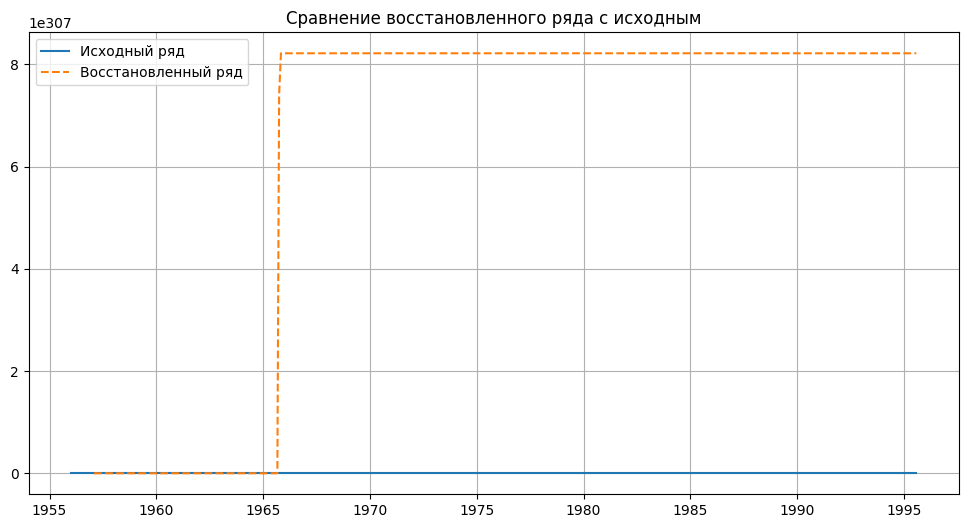

In [974]:
# Восстанавливаем из `diff_series_2`
restored_series = inverse_transform(diff_series_2, log_series)
print(data["Units"])
print(restored_series)

utils = data["Units"][len(data["Units"])- len(restored_series):]

# Сравниваем восстановленный ряд с исходным
plt.figure(figsize=(12, 6))
plt.plot(data["Units"], label="Исходный ряд")
plt.plot(restored_series, label="Восстановленный ряд", linestyle="--")
plt.title("Сравнение восстановленного ряда с исходным")
plt.legend()
plt.grid()
plt.show()


In [975]:
df = pd.DataFrame(log_series)

# Сохранение в файл Excel
df.to_excel("output.xlsx", index=True)  # index=False, чтобы не сохранять индекс как отдельный столбец

print("Данные успешно сохранены в файл output.xlsx")
log_series

Данные успешно сохранены в файл output.xlsx


Month
1956-01-01    7.134094
1956-02-01    7.162397
1956-03-01    7.229114
1956-04-01    7.204893
1956-05-01    7.336286
                ...   
1995-04-01    9.475163
1995-05-01    9.565775
1995-06-01    9.580040
1995-07-01    9.639457
1995-08-01    9.578934
Name: Units, Length: 476, dtype: float64

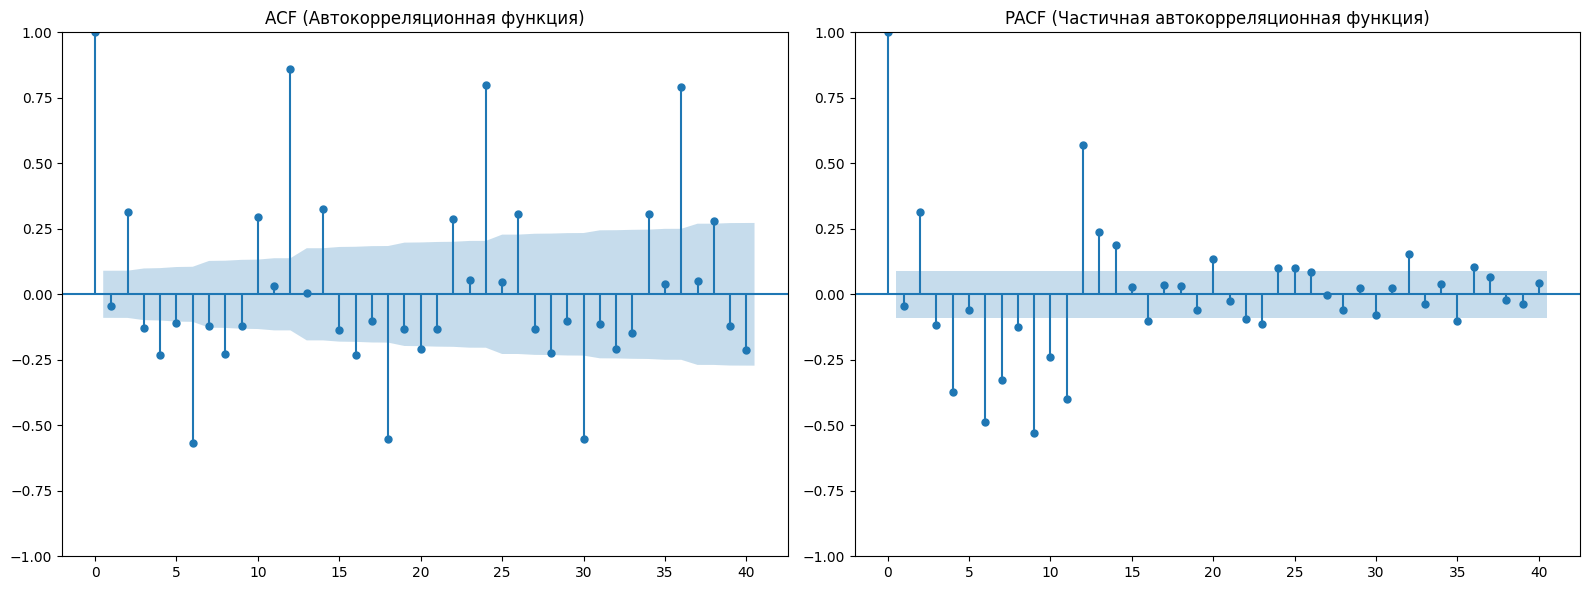

In [976]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Построение графиков ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График ACF
plot_acf(diff_series_1, lags=40, ax=axes[0])
axes[0].set_title("ACF (Автокорреляционная функция)")

# График PACF
plot_pacf(diff_series_1, lags=40, ax=axes[1])
axes[1].set_title("PACF (Частичная автокорреляционная функция)")

# Показать графики
plt.tight_layout()
plt.show()


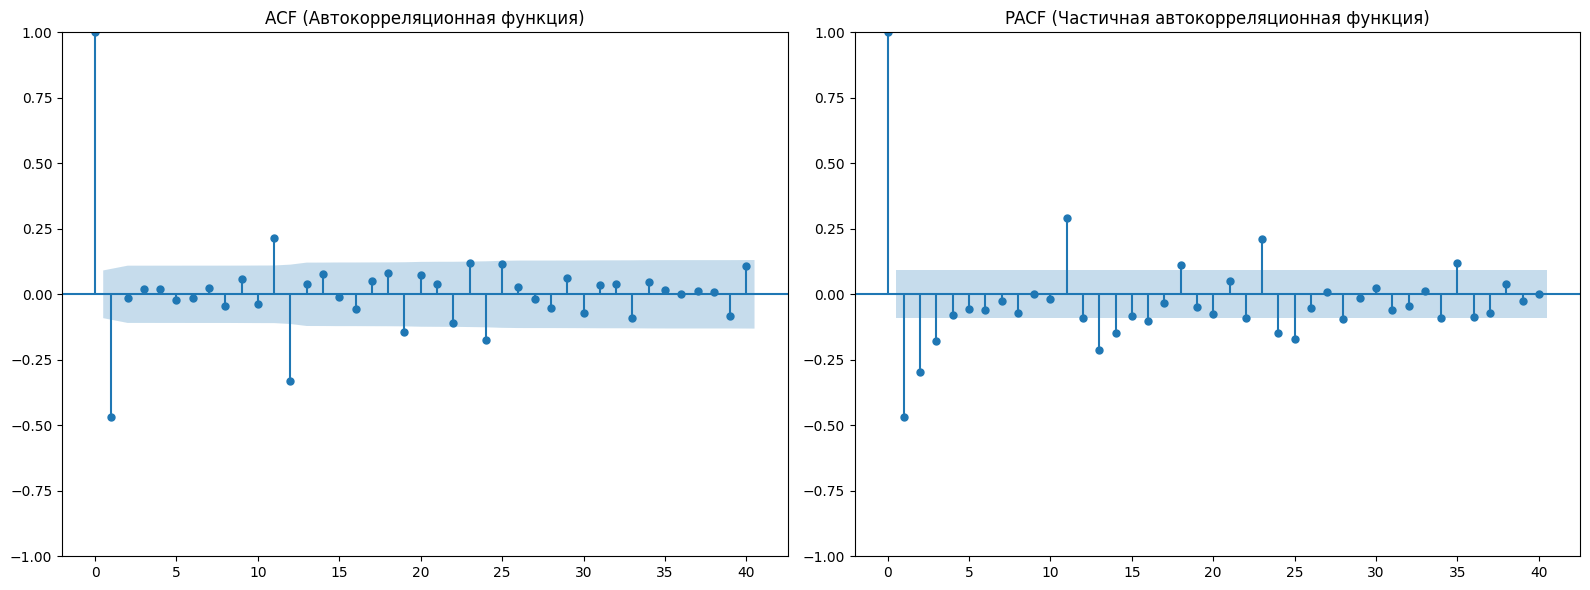

In [977]:
# Построение графиков ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График ACF
plot_acf(diff_series_2, lags=40, ax=axes[0])
axes[0].set_title("ACF (Автокорреляционная функция)")

# График PACF
plot_pacf(diff_series_2, lags=40, ax=axes[1])
axes[1].set_title("PACF (Частичная автокорреляционная функция)")

# Показать графики
plt.tight_layout()
plt.show()

## Результаты

In [978]:
file_path = "model2.xlsx"  # Замените на свой путь
data_model = pd.read_excel(file_path)
restored_series = data_model
print(data)
print(restored_series)

start_y = data["Units"][50:]
finish_y = np.exp(restored_series[50:])

# Установка индексов
start_y.index = pd.to_datetime(start_y.index)
finish_y = finish_y[-len(start_y):]  # Убедимся, что finish_y по длине не больше start_y
finish_y.index = start_y.index[-len(finish_y):]  # Совместим индексы
# Ограничим finish_y до хвоста
n = len(data["Units"])
test_size = n // 10  # 10% данных для хвоста
tail_start = len(finish_y) - test_size

# Преобразуем finish_y_reset в Series
finish_y = finish_y.squeeze()

diff_finish1 = np.log(finish_y[tail_start:]).diff()#.dropna()
diff_start1 = np.log(start_y[tail_start:]).diff()#.dropna()

diff_finish2 = diff_finish1.diff(12)#.dropna()
diff_start2 = diff_start1.diff(12)#.dropna()

# Теперь можно выполнить вычитание
# residuals = np.log(finish_y[tail_start:]) - np.log(start_y[tail_start:])
# residuals = diff_finish1 - diff_start1
residuals = diff_finish2 - diff_start2
residuals = residuals.dropna()


# Проверяем результат
residuals_arima2 = residuals


            Units
Month            
1956-01-01   1254
1956-02-01   1290
1956-03-01   1379
1956-04-01   1346
1956-05-01   1535
...           ...
1995-04-01  13032
1995-05-01  14268
1995-06-01  14473
1995-07-01  15359
1995-08-01  14457

[476 rows x 1 columns]
            0
0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
..        ...
471  9.531504
472  9.619853
473  9.639155
474  9.698153
475  9.688581

[476 rows x 1 columns]


In [979]:

file_path = "model.xlsx"  # Замените на свой путь
data_model = pd.read_excel(file_path) 

In [980]:
restored_series = data_model
print(data)
print(restored_series)

start_y = data["Units"][50:]
finish_y = np.exp(restored_series[50:])

            Units
Month            
1956-01-01   1254
1956-02-01   1290
1956-03-01   1379
1956-04-01   1346
1956-05-01   1535
...           ...
1995-04-01  13032
1995-05-01  14268
1995-06-01  14473
1995-07-01  15359
1995-08-01  14457

[476 rows x 1 columns]
            0
0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
..        ...
471  9.527583
472  9.615653
473  9.634757
474  9.692518
475  9.684543

[476 rows x 1 columns]


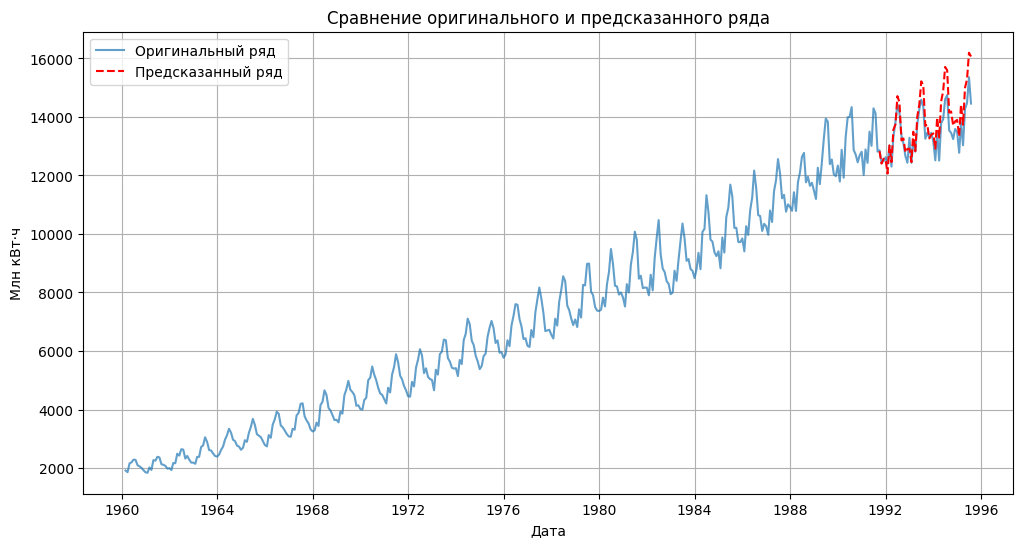

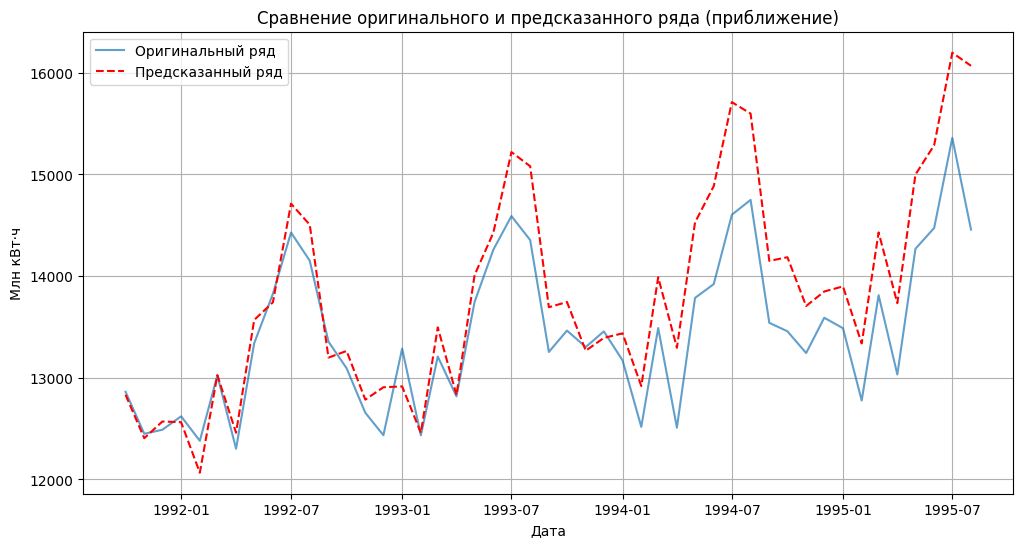

In [981]:


# Установка индексов
start_y.index = pd.to_datetime(start_y.index)
finish_y = finish_y[-len(start_y):]  # Убедимся, что finish_y по длине не больше start_y
finish_y.index = start_y.index[-len(finish_y):]  # Совместим индексы
# Ограничим finish_y до хвоста
n = len(data["Units"])
test_size = n // 10  # 10% данных для хвоста
tail_start = len(finish_y) - test_size

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(start_y, label="Оригинальный ряд", alpha=0.7)
plt.plot(finish_y[tail_start:], label="Предсказанный ряд", linestyle="--", color="red")
plt.title("Сравнение оригинального и предсказанного ряда")
plt.xlabel("Дата")
plt.ylabel("Млн кВт·ч")
plt.legend()
plt.grid()
plt.show()

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(start_y[tail_start:], label="Оригинальный ряд", alpha=0.7)
plt.plot(finish_y[tail_start:], label="Предсказанный ряд", linestyle="--", color="red")
plt.title("Сравнение оригинального и предсказанного ряда (приближение)")
plt.xlabel("Дата")
plt.ylabel("Млн кВт·ч")
plt.legend()
plt.grid()
plt.show()

## Анализ остатков


In [982]:
# Преобразуем finish_y_reset в Series
finish_y = finish_y.squeeze()

diff_finish1 = np.log(finish_y[tail_start:]).diff()#.dropna()
diff_start1 = np.log(start_y[tail_start:]).diff()#.dropna()

diff_finish2 = diff_finish1.diff(12)#.dropna()
diff_start2 = diff_start1.diff(12)#.dropna()

# Теперь можно выполнить вычитание
# residuals = np.log(finish_y[tail_start:]) - np.log(start_y[tail_start:])
# residuals = diff_finish1 - diff_start1
residuals = diff_finish2 - diff_start2
residuals = residuals.dropna()


# Проверяем результат
print(residuals)

Month
1992-11-01   -0.001592
1992-12-01    0.017152
1993-01-01   -0.054565
1993-02-01    0.051491
1993-03-01   -0.006461
1993-04-01   -0.032887
1993-05-01    0.013652
1993-06-01    0.015651
1993-07-01    0.005086
1993-08-01    0.001931
1993-09-01    0.019764
1993-10-01   -0.036631
1993-11-01   -0.020618
1993-12-01   -0.029179
1994-01-01    0.090409
1994-02-01   -0.018820
1994-03-01   -0.014667
1994-04-01    0.044967
1994-05-01   -0.026448
1994-06-01    0.021875
1994-07-01   -0.024436
1994-08-01   -0.024273
1994-09-01    0.004805
1994-10-01    0.020631
1994-11-01    0.005005
1994-12-01   -0.013443
1995-01-01   -0.013545
1995-02-01    0.001368
1995-03-01   -0.004072
1995-04-01   -0.015840
1995-05-01    0.005915
1995-06-01   -0.009618
1995-07-01   -0.007815
1995-08-01    0.069676
dtype: float64


In [983]:
# residuals_arima2 = residuals
residuals_arima1 = residuals

In [984]:
residuals_arima2

Month
1992-11-01   -0.002502
1992-12-01    0.016556
1993-01-01   -0.053164
1993-02-01    0.051568
1993-03-01   -0.006508
1993-04-01   -0.033970
1993-05-01    0.015554
1993-06-01    0.016204
1993-07-01    0.003106
1993-08-01    0.002564
1993-09-01    0.020169
1993-10-01   -0.037841
1993-11-01   -0.020300
1993-12-01   -0.028403
1994-01-01    0.089635
1994-02-01   -0.018986
1994-03-01   -0.015262
1994-04-01    0.046136
1994-05-01   -0.027241
1994-06-01    0.019798
1994-07-01   -0.021900
1994-08-01   -0.025407
1994-09-01    0.005357
1994-10-01    0.021401
1994-11-01    0.004657
1994-12-01   -0.013613
1995-01-01   -0.014109
1995-02-01    0.002282
1995-03-01   -0.003781
1995-04-01   -0.016078
1995-05-01    0.005764
1995-06-01   -0.007654
1995-07-01   -0.008690
1995-08-01    0.069598
dtype: float64

## Анализ остатков

Среднее значение остатков: 0.0010138585295894425


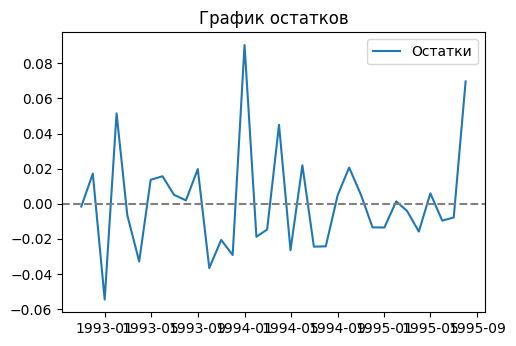

In [985]:
# # Предположим, остатки модели ARIMA сохранены в residuals (Pandas Series или NumPy array)
# # Пример: residuals = fitted_model.resid
# residuals = np.random.normal(0, 1, 100)  # Пример данных

# Визуализация остатков
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(residuals, label="Остатки")
plt.axhline(0, linestyle="--", color="gray")
plt.title("График остатков")
plt.legend()

# Проверка на несмещенность: Среднее значение остатков должно быть близким к нулю
mean_residuals = residuals.mean()
print(f"Среднее значение остатков: {mean_residuals}")




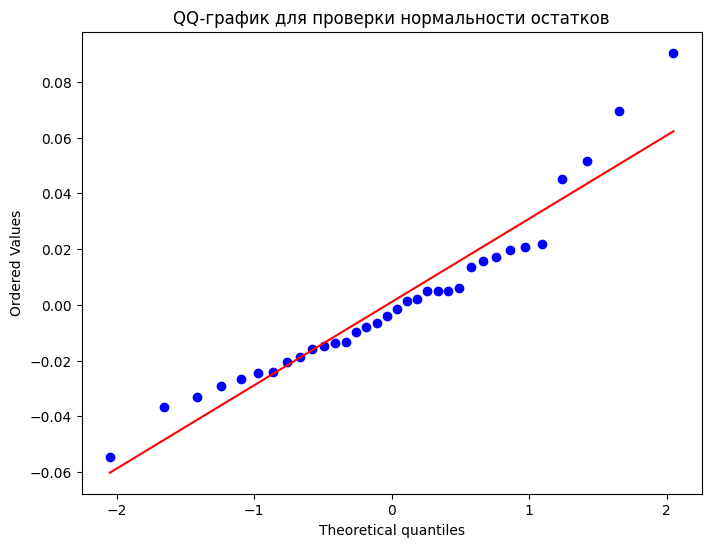

In [986]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Строим QQ-график для проверки нормальности
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-график для проверки нормальности остатков")
plt.show()


In [987]:
from scipy.stats import shapiro

# Применяем критерий Шапиро-Уилка для проверки нормальности
stat, p_value = shapiro(residuals)

print(f"Статистика Шапиро-Уилка: {stat}")
print(f"p-значение: {p_value}")

# Интерпретация
if p_value < 0.05:
    print("Данные не следуют нормальному распределению (гипотеза отклоняется).")
else:
    print("Данные следуют нормальному распределению.")


Статистика Шапиро-Уилка: 0.9311495615674257
p-значение: 0.03379176710753487
Данные не следуют нормальному распределению (гипотеза отклоняется).


In [988]:
from scipy.stats import wilcoxon

# Тест Уилкоксона для медианы остатков
stat, p_value = wilcoxon(residuals)

print(f"Статистика Уилкоксона: {stat}")
print(f"p-значение: {p_value}")

# Интерпретация
if p_value < 0.05:
    print("Медиана остаточных ошибок значительно отличается от нуля (несмещенные остатки отклоняются).")
else:
    print("Медиана остаточных ошибок не отличается от нуля (остатки не смещены).")


Статистика Уилкоксона: 271.0
p-значение: 0.6606290930649266
Медиана остаточных ошибок не отличается от нуля (остатки не смещены).


In [989]:
from statsmodels.tsa.stattools import kpss

# Применяем тест KPSS для проверки стационарности
stat, p_value, lags, critical_values = kpss(residuals, regression='c', nlags='auto')

print(f"Статистика KPSS: {stat}")
print(f"p-значение: {p_value}")
print(f"Критические значения: {critical_values}")

# Интерпретация
if p_value < 0.05:
    print("Данные нестационарны (гипотеза о стационарности отклоняется).")
else:
    print("Данные стационарны.")


Статистика KPSS: 0.40412625783390294
p-значение: 0.07537661300262805
Критические значения: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Данные стационарны.


     lb_stat  lb_pvalue
1   4.310131   0.037886
2   4.886607   0.086873
3   5.243290   0.154825
4   5.830866   0.212140
5   5.886908   0.317379
6   6.134260   0.408320
7   6.301443   0.505025
8   6.498652   0.591557
9   6.616797   0.676947
10  6.715874   0.751968
Лаг 1: Остатки автокоррелированы (p = 0.038)
Лаг 2: Нет автокорреляции (p = 0.087)
Лаг 3: Нет автокорреляции (p = 0.155)
Лаг 4: Нет автокорреляции (p = 0.212)
Лаг 5: Нет автокорреляции (p = 0.317)
Лаг 6: Нет автокорреляции (p = 0.408)
Лаг 7: Нет автокорреляции (p = 0.505)
Лаг 8: Нет автокорреляции (p = 0.592)
Лаг 9: Нет автокорреляции (p = 0.677)
Лаг 10: Нет автокорреляции (p = 0.752)


<Figure size 1000x600 with 0 Axes>

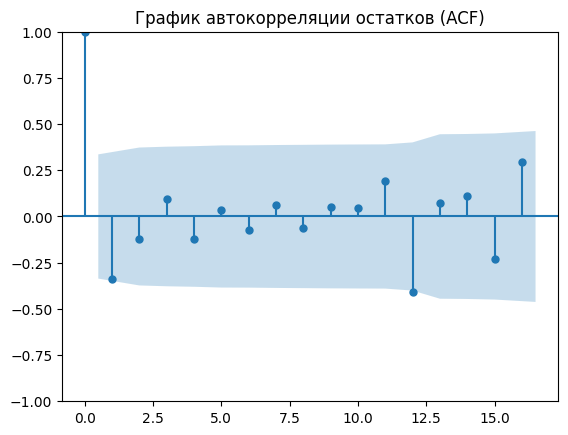

In [990]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Выполняем тест Льюнга-Бокса
# 'lags' указывает количество лагов для проверки автокорреляции
lags = 10  # Выберите нужное количество лагов
lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)

# Выводим результаты теста
print(lb_test)

# Интерпретация результатов
for lag, p_value in enumerate(lb_test["lb_pvalue"], start=1):
    if p_value < 0.05:
        print(f"Лаг {lag}: Остатки автокоррелированы (p = {p_value:.3f})")
    else:
        print(f"Лаг {lag}: Нет автокорреляции (p = {p_value:.3f})")





# 2. График автокорреляции (ACF) с ограничением количества лагов
plt.figure(figsize=(10, 6))
plot_acf(residuals)  # Выбираем ограниченное количество лагов
plt.title("График автокорреляции остатков (ACF)")
plt.show()



In [991]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf

c:\Users\Varya02\envs\project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


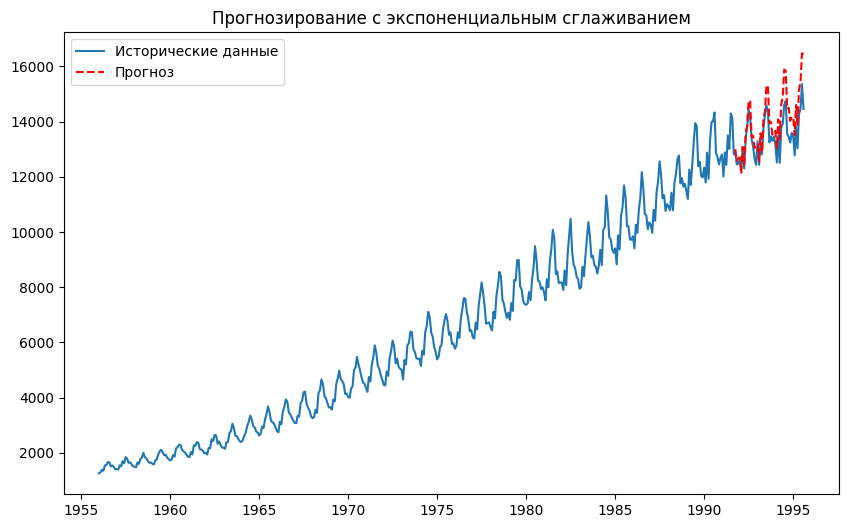

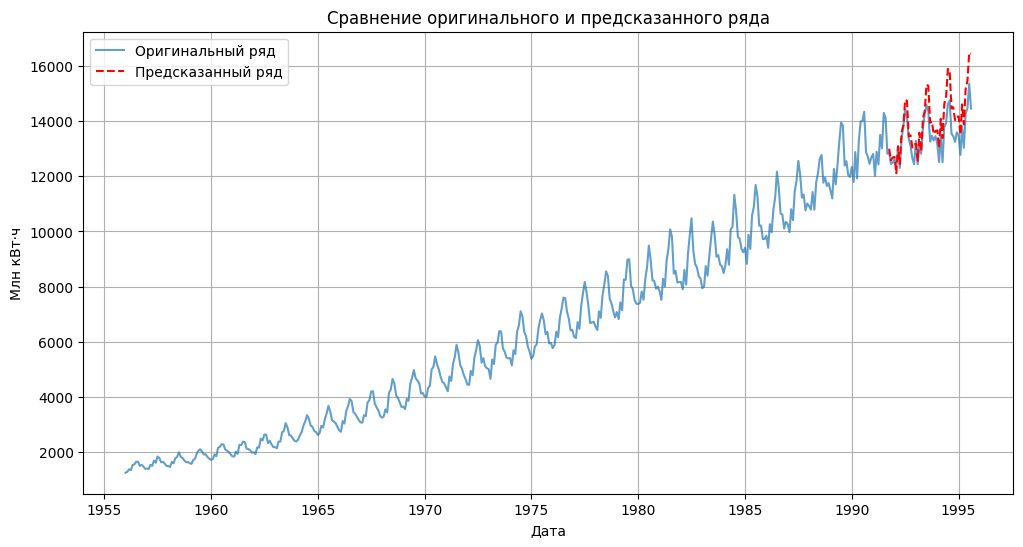

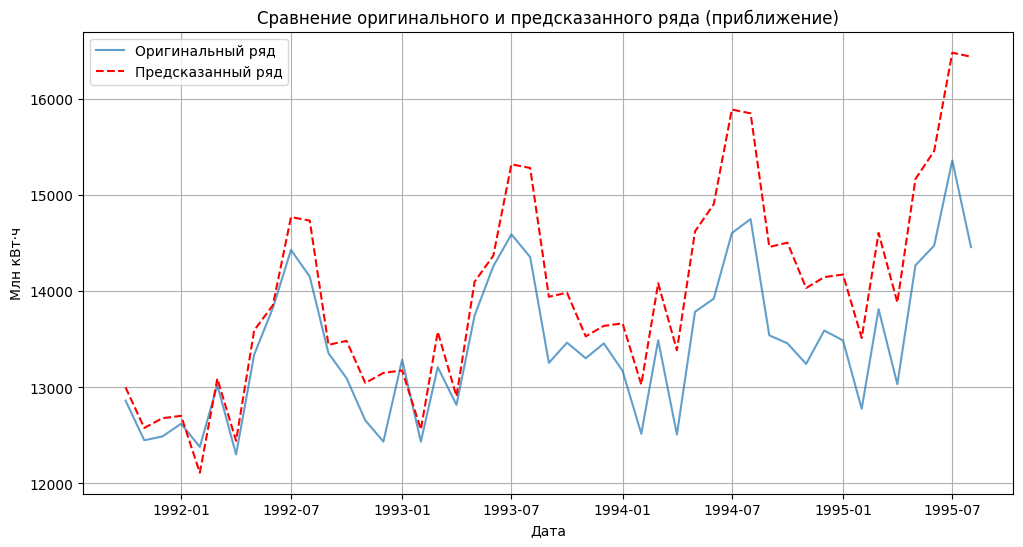

In [992]:
n = len(log_series)

# Длина тестовой выборки (1/10 от ряда)
test_size = n // 10

# Разделение на обучающую и тестовую выборки
train_data = log_series[:-test_size]

model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# Прогнозирование
forecast = fitted_model.forecast(steps=test_size)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(np.exp(log_series), label='Исторические данные')
# plt.plot(fitted_model.fittedvalues, label='Подогнанные данные', linestyle='--')
plt.plot(np.exp(forecast), label='Прогноз', linestyle='--', color='red')
plt.title('Прогнозирование с экспоненциальным сглаживанием')
plt.legend()
plt.show()
# Преобразование в оригинальные значения (exp)
start_y = np.exp(log_series)
finish_y = np.exp(forecast)

# Определение точки, с которой начать отображение на графике
tail_start = len(log_series) - test_size

# Визуализация оригинального и предсказанного ряда
plt.figure(figsize=(12, 6))
plt.plot(start_y, label="Оригинальный ряд", alpha=0.7)
plt.plot(finish_y, label="Предсказанный ряд", linestyle="--", color="red")
plt.title("Сравнение оригинального и предсказанного ряда")
plt.xlabel("Дата")
plt.ylabel("Млн кВт·ч")
plt.legend()
plt.grid()
plt.show()

# Визуализация с приближением
plt.figure(figsize=(12, 6))
plt.plot(start_y[tail_start:], label="Оригинальный ряд", alpha=0.7)
plt.plot(finish_y, label="Предсказанный ряд", linestyle="--", color="red")
plt.title("Сравнение оригинального и предсказанного ряда (приближение)")
plt.xlabel("Дата")
plt.ylabel("Млн кВт·ч")
plt.legend()
plt.grid()
plt.show()

In [993]:
# Параметры модели
print(fitted_model.params)

# Подробное описание модели
print(fitted_model.summary())


{'smoothing_level': np.float64(0.2440225795128793), 'smoothing_trend': np.float64(0.02192905209765018), 'smoothing_seasonal': np.float64(0.3365069960192207), 'damping_trend': nan, 'initial_level': np.float64(7.2387525623808955), 'initial_trend': np.float64(0.006725978511070765), 'initial_seasons': array([-0.10456454, -0.10621035, -0.0212317 , -0.0488834 ,  0.06686917,
        0.06123715,  0.12910051,  0.0943033 ,  0.0057571 ,  0.00362435,
       -0.03785081, -0.08835387]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Units   No. Observations:                  429
Model:             ExponentialSmoothing   SSE                              0.194
Optimized:                         True   AIC                          -3272.744
Trend:                         Additive   BIC                          -3207.761
Seasonal:                      Additive   AICC             

## Анализ остатков

In [994]:
# Преобразуем finish_y_reset в Series
finish_y = finish_y.squeeze()

diff_finish1 = np.log(finish_y).diff()#.dropna()
diff_start1 = np.log(start_y[tail_start:]).diff()#.dropna()

diff_finish2 = diff_finish1.diff(12)#.dropna()
diff_start2 = diff_start1.diff(12)#.dropna()

# Теперь можно выполнить вычитание
# residuals = np.log(finish_y[tail_start:]) - np.log(start_y[tail_start:])
# residuals = diff_finish1 - diff_start1
residuals = diff_finish2 - diff_start2
# residuals = np.log(finish_y) - np.log(start_y[tail_start:])
residuals = residuals.dropna()

# Проверяем результат
print(residuals)

1992-11-01    0.001386
1992-12-01    0.020824
1993-01-01   -0.055757
1993-02-01    0.047072
1993-03-01   -0.009829
1993-04-01   -0.026829
1993-05-01    0.010955
1993-06-01   -0.000854
1993-07-01    0.019744
1993-08-01   -0.003078
1993-09-01    0.021835
1993-10-01   -0.035457
1993-11-01   -0.021918
1993-12-01   -0.029127
1994-01-01    0.087679
1994-02-01   -0.015422
1994-03-01   -0.014323
1994-04-01    0.045300
1994-05-01   -0.027157
1994-06-01    0.026823
1994-07-01   -0.024880
1994-08-01   -0.026256
1994-09-01    0.005798
1994-10-01    0.021869
1994-11-01    0.003925
1994-12-01   -0.014354
1995-01-01   -0.013800
1995-02-01    0.003228
1995-03-01   -0.003183
1995-04-01   -0.017296
1995-05-01    0.006521
1995-06-01   -0.004448
1995-07-01   -0.011588
1995-08-01    0.070471
Freq: MS, dtype: float64


Среднее значение остатков: 0.001113924701684986


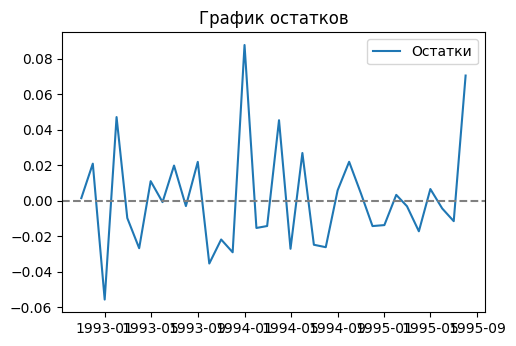

In [995]:
# Визуализация остатков
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(residuals, label="Остатки")
plt.axhline(0, linestyle="--", color="gray")
plt.title("График остатков")
plt.legend()

# Проверка на несмещенность: Среднее значение остатков должно быть близким к нулю
mean_residuals = residuals.mean()
print(f"Среднее значение остатков: {mean_residuals}")

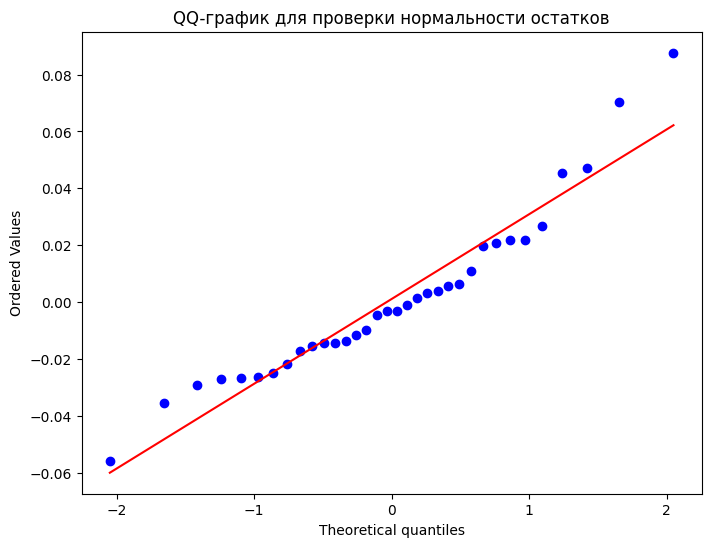

In [996]:

# Строим QQ-график для проверки нормальности
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-график для проверки нормальности остатков")
plt.show()




In [997]:
# Применяем критерий Шапиро-Уилка для проверки нормальности
stat, p_value = shapiro(residuals)

print(f"Статистика Шапиро-Уилка: {stat}")
print(f"p-значение: {p_value}")

# Интерпретация
if p_value < 0.05:
    print("Данные не следуют нормальному распределению (гипотеза отклоняется).")
else:
    print("Данные следуют нормальному распределению.")


    

Статистика Шапиро-Уилка: 0.935002516217676
p-значение: 0.04383903617357345
Данные не следуют нормальному распределению (гипотеза отклоняется).


In [998]:
# Тест Уилкоксона для медианы остатков
stat, p_value = wilcoxon(residuals)

print(f"Статистика Уилкоксона: {stat}")
print(f"p-значение: {p_value}")

# Интерпретация
if p_value < 0.05:
    print("Медиана остаточных ошибок значительно отличается от нуля (несмещенные остатки отклоняются).")
else:
    print("Медиана остаточных ошибок не отличается от нуля (остатки не смещены).")

from statsmodels.tsa.stattools import kpss

# Применяем тест KPSS для проверки стационарности
stat, p_value, lags, critical_values = kpss(residuals, regression='c', nlags='auto')

print(f"Статистика KPSS: {stat}")
print(f"p-значение: {p_value}")
print(f"Критические значения: {critical_values}")

# Интерпретация
if p_value < 0.05:
    print("Данные нестационарны (гипотеза о стационарности отклоняется).")
else:
    print("Данные стационарны.")

Статистика Уилкоксона: 272.0
p-значение: 0.6729288285132498
Медиана остаточных ошибок не отличается от нуля (остатки не смещены).
Статистика KPSS: 0.25232705208690487
p-значение: 0.1
Критические значения: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Данные стационарны.


C:\Users\Varya02\AppData\Local\Temp\ipykernel_12320\1422361555.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, lags, critical_values = kpss(residuals, regression='c', nlags='auto')


     lb_stat  lb_pvalue
1   4.923153   0.026499
2   5.072897   0.079147
3   5.157177   0.160643
4   5.870305   0.209046
5   6.189699   0.288196
6   6.412807   0.378569
7   6.436896   0.489758
8   6.723465   0.566741
9   7.420979   0.593377
10  7.439677   0.683386
Лаг 1: Остатки автокоррелированы (p = 0.026)
Лаг 2: Нет автокорреляции (p = 0.079)
Лаг 3: Нет автокорреляции (p = 0.161)
Лаг 4: Нет автокорреляции (p = 0.209)
Лаг 5: Нет автокорреляции (p = 0.288)
Лаг 6: Нет автокорреляции (p = 0.379)
Лаг 7: Нет автокорреляции (p = 0.490)
Лаг 8: Нет автокорреляции (p = 0.567)
Лаг 9: Нет автокорреляции (p = 0.593)
Лаг 10: Нет автокорреляции (p = 0.683)


<Figure size 1000x600 with 0 Axes>

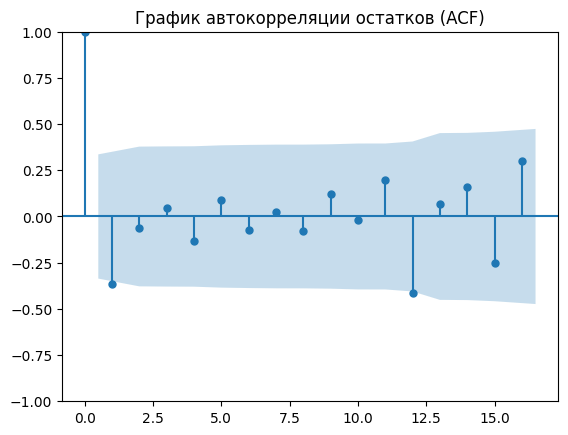

In [999]:
# Выполняем тест Льюнга-Бокса
# 'lags' указывает количество лагов для проверки автокорреляции
lags = 10  # Выберите нужное количество лагов
lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)

# Выводим результаты теста
print(lb_test)

# Интерпретация результатов
for lag, p_value in enumerate(lb_test["lb_pvalue"], start=1):
    if p_value < 0.05:
        print(f"Лаг {lag}: Остатки автокоррелированы (p = {p_value:.3f})")
    else:
        print(f"Лаг {lag}: Нет автокорреляции (p = {p_value:.3f})")





# 2. График автокорреляции (ACF) с ограничением количества лагов
plt.figure(figsize=(10, 6))
plot_acf(residuals)  # Выбираем ограниченное количество лагов
plt.title("График автокорреляции остатков (ACF)")
plt.show()

In [1000]:
print(residuals_arima1)
print(residuals_arima2)
residuals_se = residuals
print(residuals_se)

Month
1992-11-01   -0.001592
1992-12-01    0.017152
1993-01-01   -0.054565
1993-02-01    0.051491
1993-03-01   -0.006461
1993-04-01   -0.032887
1993-05-01    0.013652
1993-06-01    0.015651
1993-07-01    0.005086
1993-08-01    0.001931
1993-09-01    0.019764
1993-10-01   -0.036631
1993-11-01   -0.020618
1993-12-01   -0.029179
1994-01-01    0.090409
1994-02-01   -0.018820
1994-03-01   -0.014667
1994-04-01    0.044967
1994-05-01   -0.026448
1994-06-01    0.021875
1994-07-01   -0.024436
1994-08-01   -0.024273
1994-09-01    0.004805
1994-10-01    0.020631
1994-11-01    0.005005
1994-12-01   -0.013443
1995-01-01   -0.013545
1995-02-01    0.001368
1995-03-01   -0.004072
1995-04-01   -0.015840
1995-05-01    0.005915
1995-06-01   -0.009618
1995-07-01   -0.007815
1995-08-01    0.069676
dtype: float64
Month
1992-11-01   -0.002502
1992-12-01    0.016556
1993-01-01   -0.053164
1993-02-01    0.051568
1993-03-01   -0.006508
1993-04-01   -0.033970
1993-05-01    0.015554
1993-06-01    0.016204
1993-07

In [1001]:
from statsmodels.tsa.stattools import acf, diebold_mariano

# Сравнение моделей
dm_stat_arima_vs_manual, p_value_arima_vs_manual = diebold_mariano(residuals_arima1, residuals_arima2)
dm_stat_arima_vs_es, p_value_arima_vs_es = diebold_mariano(residuals_arima1, residuals_se)
dm_stat_manual_vs_es, p_value_manual_vs_es = diebold_mariano(residuals_arima2, residuals_se)

# Вывод результатов
print(f"ARIMA vs Manual: DM Stat = {dm_stat_arima_vs_manual}, p-value = {p_value_arima_vs_manual}")
print(f"ARIMA vs ES: DM Stat = {dm_stat_arima_vs_es}, p-value = {p_value_arima_vs_es}")
print(f"Manual vs ES: DM Stat = {dm_stat_manual_vs_es}, p-value = {p_value_manual_vs_es}")


ImportError: cannot import name 'diebold_mariano' from 'statsmodels.tsa.stattools' (c:\Users\Varya02\envs\project\Lib\site-packages\statsmodels\tsa\stattools.py)

In [962]:
import statsmodels
print(statsmodels.__version__)


0.14.4


In [963]:
import numpy as np

def diebold_mariano_test(e1, e2, h=1):
    """
    Тест Диболда-Мариано для сравнения двух моделей прогнозирования.

    Параметры:
    - e1: Ошибки модели 1 (numpy array)
    - e2: Ошибки модели 2 (numpy array)
    - h: Горизонт прогнозирования (по умолчанию 1)

    Возвращает:
    - DM_stat: Статистика теста
    - p_value: p-значение теста
    """
    d = e1**2 - e2**2  # Разница ошибок
    mean_d = np.mean(d)  # Средняя разница
    var_d = np.var(d, ddof=1)  # Дисперсия разницы
    n = len(d)

    # Корректировка для горизонта прогнозирования
    S = (1 / n) * sum([(1 - k / h) * np.cov(d[:-k], d[k:])[0, 1] for k in range(1, h)])
    DM_stat = mean_d / np.sqrt((var_d + 2 * S) / n)

    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(abs(DM_stat)))

    return DM_stat, p_value


In [966]:
# Остатки моделей
e1 = residuals_arima1  # Ошибки модели ARIMA
e2 = residuals_se  # Ошибки вручную настроенной модели

if len(e1) != len(e2):
    raise ValueError("Ошибки моделей должны быть одинаковой длины.")
if np.any(np.isnan(e1)) or np.any(np.isnan(e2)):
    raise ValueError("Ошибки моделей содержат NaN.")
if np.allclose(e1, e2):
    raise ValueError("Ошибки моделей идентичны, невозможно выполнить тест.")


# Проведение теста
dm_stat, p_value = diebold_mariano_test(e1, e2)

print(f"DM Statistic: {dm_stat}, p-value: {p_value}")

DM Statistic: 0.2924447845197824, p-value: 0.7699465709266493


In [1005]:
# Остатки моделей
e1 = residuals_arima1  # Остатки вручную настроенной модели ARIMA
e2 = residuals_arima2  # Остатки автоматически настроенной модели ARIMA
e3 = residuals_se # Остатки модели с экспоненциальным сглаживанием

if len(e1) != len(e2):
    raise ValueError("Ошибки моделей должны быть одинаковой длины.")
if np.any(np.isnan(e1)) or np.any(np.isnan(e2)):
    raise ValueError("Ошибки моделей содержат NaN.")
if np.allclose(e1, e2):
    raise ValueError("Ошибки моделей идентичны, невозможно выполнить тест.")


# Проведение теста
dm_stat, p_value = diebold_mariano_test(e1, e2)

print(f"DM Statistic: {dm_stat}, p-value: {p_value}")

DM Statistic: 0.18601933343533678, p-value: 0.8524296000479721


In [1006]:
model_pairs = [
    ("ARIMA (Manual)", "ARIMA (Auto)", e1, e2),
    ("ARIMA (Manual)", "Exp Smoothing", e1, e3),
    ("ARIMA (Auto)", "Exp Smoothing", e2, e3)
]

# Проведение теста для каждой пары
for model1, model2, residuals1, residuals2 in model_pairs:
    dm_stat, p_value = diebold_mariano_test(residuals1, residuals2)
    print(f"Comparison: {model1} vs {model2}")
    print(f"DM Statistic: {dm_stat:.4f}, p-value: {p_value:.4f}\n")

Comparison: ARIMA (Manual) vs ARIMA (Auto)
DM Statistic: 0.1860, p-value: 0.8524

Comparison: ARIMA (Manual) vs Exp Smoothing
DM Statistic: 0.2924, p-value: 0.7699

Comparison: ARIMA (Auto) vs Exp Smoothing
DM Statistic: 0.2153, p-value: 0.8295

